Imports and Configuration

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from glob import glob
import pickle  # For caching

IMAGE_FOLDER = "E:/Coding/Advanced ML/train_data"
LABELS_FILE = "E:/Coding/Advanced ML/train.csv"
IMG_SIZE = (64, 64)
PCA_CACHE_FILE = "pca_results_rgbw.pkl"  # Cache file for PCA

Image Loading Function

In [43]:
def load_images_from_folder(folder, size=IMG_SIZE):
    images = []
    filenames = []
    for filename in glob(os.path.join(folder, "*.jpg")):  # Or other extensions
        img = cv2.imread(filename)
        if img is not None:  # Check if image was read successfully
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            filenames.append(os.path.basename(filename))
        else:
            print(f"Warning: Could not read image {filename}. Skipping.")
    return images, filenames

RGBW Feature Extraction Function

In [44]:
def extract_rgbw_features(image):
    r, g, b = cv2.split(image)
    w = (r + g + b) / 3  # White component as average of RGB
    return np.array([r.mean(), g.mean(), b.mean(), w.mean()])

Load Labels

In [45]:
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = dict(zip(labels_df['file_name'], labels_df['label']))

Process Images and Perform PCA with Caching

In [46]:
def process_images_and_pca(image_folder, labels_dict, img_size=IMG_SIZE, cache_file=PCA_CACHE_FILE):
    if os.path.exists(cache_file):
        print("Loading PCA results from cache...")
        with open(cache_file, 'rb') as f:
            df_pca, df_rgbw, scaler, pca = pickle.load(f)  # Load df_rgbw as well
            return df_pca, df_rgbw, scaler, pca # Return it
    else:
        print("Processing images and performing PCA...")
        images, filenames = load_images_from_folder(image_folder, img_size)
        features = np.array([extract_rgbw_features(img) for img in images])

        df_rgbw = pd.DataFrame(features, columns=['Red', 'Green', 'Blue', 'White'])  # Define df_rgbw here
        df_rgbw['Image'] = filenames
        df_rgbw['Label'] = df_rgbw['Image'].map(lambda x: labels_dict.get(f"train_data/{x}", np.nan))

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(features_scaled)

        df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
        df_pca['Image'] = filenames
        df_pca['Label'] = df_rgbw['Label']

        with open(cache_file, 'wb') as f:
            pickle.dump((df_pca, df_rgbw, scaler, pca), f)  # Cache df_rgbw too
        return df_pca, df_rgbw, scaler, pca  # Return df_rgbw

Execute PCA and Load from Cache if Available

In [47]:
df_pca, df_rgbw, scaler, pca = process_images_and_pca(IMAGE_FOLDER, labels_dict)

Loading PCA results from cache...


Display RGBW Table

In [48]:
print("RGBW Values of Images with Labels:")
print(df_rgbw[['Red', 'Green', 'Blue', 'White', 'Label', 'Image']])

RGBW Values of Images with Labels:
              Red       Green        Blue      White  Label  \
0      181.152588  176.425781  176.861328  47.750732      0   
1      130.607666   99.067139   55.423584  35.720296      1   
2      146.630615   92.545410   36.175049  39.367025      0   
3      244.734131  204.105957  124.103271  53.876953      0   
4      131.071045  141.335693  152.371826  48.197021      0   
...           ...         ...         ...        ...    ...   
79945  216.273438  195.844971  168.042969  54.782959      1   
79946   79.455566   58.445068   30.175293  24.337809      1   
79947  111.601562  112.196533  109.803223  40.637939      0   
79948  140.229980  148.943115  157.530518  49.213704      1   
79949  141.340820  141.365234  143.736816  44.064290      0   

                                      Image  
0      000295da5dca4af09d5593174e15bb09.jpg  
1      0002f7db7beb4bf5879a0cdb7f17209d.jpg  
2      0003538364d44952924d83980771e5b7.jpg  
3      00040d088f054d379

Display PCA Table

In [49]:
print("PCA Results:")
print(df_pca[['PC1', 'PC2', 'Image', 'Label']]) # Include label

PCA Results:
            PC1       PC2                                 Image  Label
0      0.969968  0.340178  000295da5dca4af09d5593174e15bb09.jpg      0
1     -2.224658 -0.653252  0002f7db7beb4bf5879a0cdb7f17209d.jpg      1
2     -2.150390 -1.227782  0003538364d44952924d83980771e5b7.jpg      0
3      1.756800 -1.347322  00040d088f054d379b1aae48e9f425d2.jpg      0
4     -0.194398  0.593356  0004501ec7a74f0ab1bed517e5fe4ee3.jpg      0
...         ...       ...                                   ...    ...
79945  1.819403 -0.356822  fff98740c23d4ac6bda41fa7e044c092.jpg      1
79946 -4.029084 -0.191092  fffc18e61cb54ecab47a9953e30c2405.jpg      1
79947 -1.513754  0.326101  fffd7b42103748aa92c65ae34c4748dd.jpg      0
79948  0.091046  0.539064  fffe1a776dec4aaa9349b67e67c9f150.jpg      1
79949 -0.362742  0.404340  fffff5fc2faf4d5185c21b4776c9cd8c.jpg      0

[79950 rows x 4 columns]


Find the optimal K

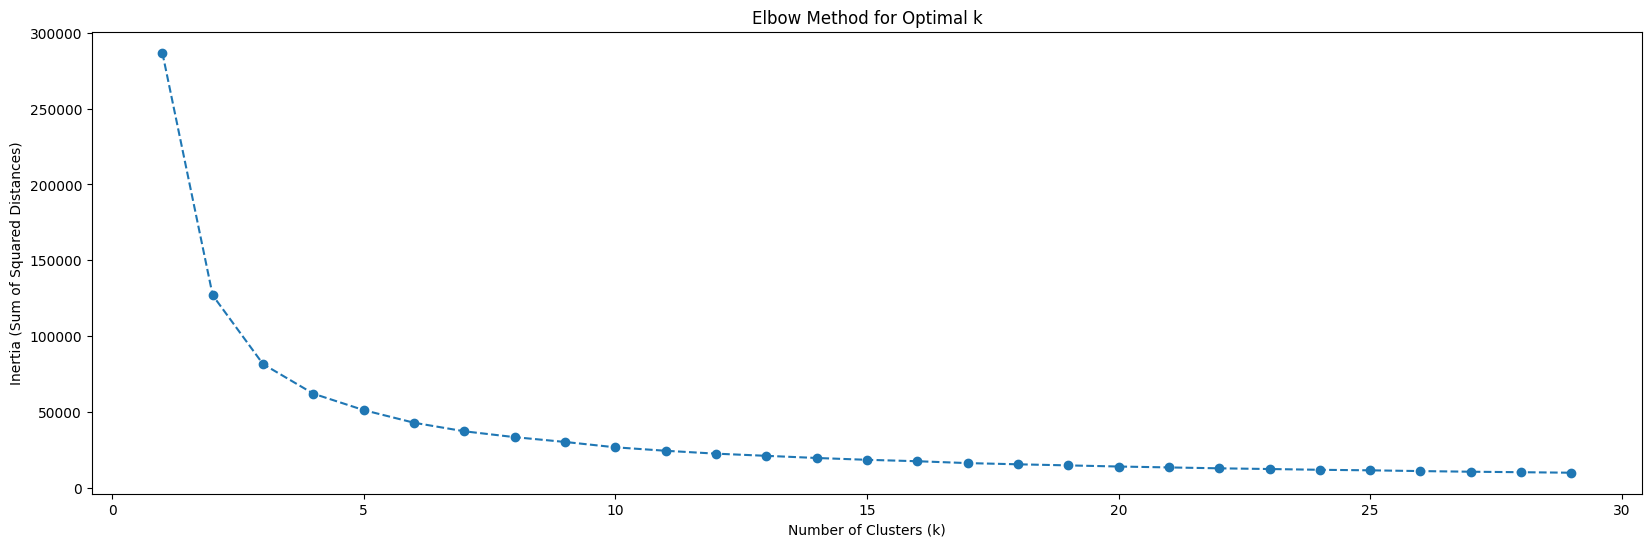

In [55]:
inertia = []
cluster_range = range(1, 30)  # Test 1 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca[['PC1', 'PC2']])
    inertia.append(kmeans.inertia_)  # Store inertia value

# Plot the Elbow Method
plt.figure(figsize=(20, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

Apply Silhouette Method

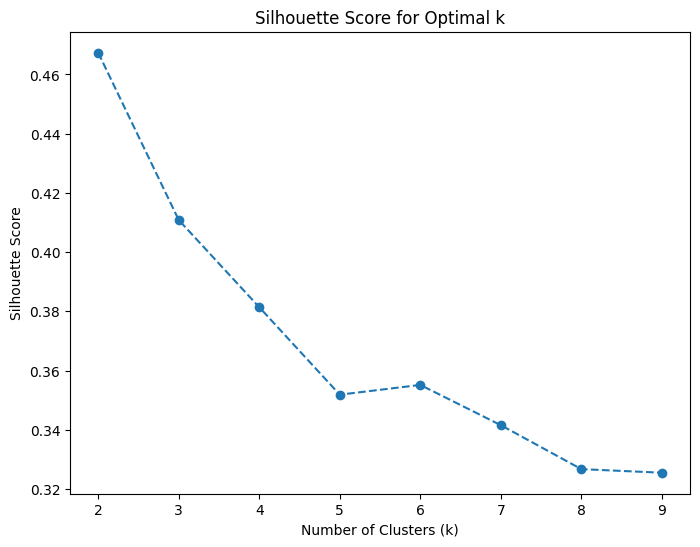

In [61]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 10):  # Silhouette needs at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca[['PC1', 'PC2']])
    score = silhouette_score(df_pca[['PC1', 'PC2']], cluster_labels)
    sil_scores.append(score)

# Plot Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

Apply K-Means Clustering

In [62]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 clusters for AI vs Human
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

Plot PCA Results

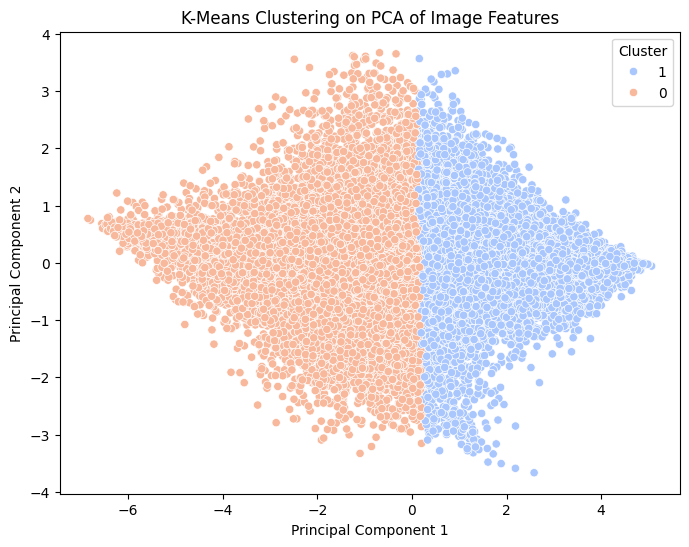

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=df_pca['Cluster'].astype(str), palette='coolwarm', data=df_pca)
plt.title('K-Means Clustering on PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()